<a href="https://colab.research.google.com/github/Jaya8306/Data-Analysis-on-Sales/blob/main/OrderOdyssey_Product_demand_forecasting_for_Q_commerce_darkstores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary libraries and Defining basic functions to be used while performing Exploratory Data Analysis.


In [ ]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

# Function to create timestamp features
def create_time_features(df, date_column):
    """
    Create time-based features from a date column
    """
    df['hour'] = df[date_column].dt.hour
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['day_of_month'] = df[date_column].dt.day
    df['month'] = df[date_column].dt.month
    df['year'] = df[date_column].dt.year
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

    # Define peak hours (can be modified based on your data)
    df['is_peak_hours'] = df['hour'].isin([8,9,12,13,17,18,19]).astype(int)

    return df

# Function for basic EDA plots
def plot_time_patterns(df, date_column, value_column):
    """
    Create basic time-based pattern plots
    """
    # Hourly patterns
    hourly = df.groupby('hour')[value_column].mean().reset_index()
    fig1 = px.line(hourly, x='hour', y=value_column,
                   title='Average Orders by Hour')
    fig1.show()

    # Daily patterns
    daily = df.groupby('day_of_week')[value_column].mean().reset_index()
    daily['day_name'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    fig2 = px.bar(daily, x='day_name', y=value_column,
                  title='Average Orders by Day of Week')
    fig2.show()

    # Monthly patterns
    monthly = df.groupby('month')[value_column].mean().reset_index()
    fig3 = px.line(monthly, x='month', y=value_column,
                   title='Average Orders by Month')
    fig3.show()

# Function to calculate basic inventory metrics
def calculate_inventory_metrics(df, demand_col, stock_col=None):
    """
    Calculate basic inventory metrics
    """
    metrics = {}

    # Total demand
    metrics['total_demand'] = df[demand_col].sum()

    # Average daily demand
    metrics['avg_daily_demand'] = df.groupby(df.index.date)[demand_col].mean().mean()

    # Demand variability
    metrics['demand_cv'] = df[demand_col].std() / df[demand_col].mean()

    # If stock data is available
    if stock_col:
        # Stock-out rate
        metrics['stockout_rate'] = (df[stock_col] == 0).mean()

        # Inventory turnover
        metrics['inventory_turnover'] = metrics['total_demand'] / df[stock_col].mean()

    return pd.Series(metrics)


Mounted at /content/drive


Since, I couldn't a relevant dark store dataset with public access. Generated a dataset using this dataset generator code.

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random

def generate_qcommerce_data(start_date='2023-01-01', end_date='2023-12-31', num_products=50):
    """
    Generate synthetic q-commerce order data
    """
    # Create date range
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')

    # Product categories typical in dark stores
    categories = [
        'Fresh Produce', 'Dairy', 'Beverages', 'Snacks',
        'Household', 'Personal Care', 'Baby Care', 'Pet Supplies'
    ]

    # Create product list with categories, prices, and base demand
    products = []
    for i in range(num_products):
        category = random.choice(categories)
        if category == 'Fresh Produce':
            price_range = (2, 10)
        elif category == 'Dairy':
            price_range = (3, 8)
        elif category == 'Beverages':
            price_range = (1, 5)
        elif category == 'Snacks':
            price_range = (2, 6)
        else:
            price_range = (5, 20)

        products.append({
            'product_id': f'P{i:03d}',
            'category': category,
            'price': round(random.uniform(*price_range), 2),
            'base_demand': random.randint(5, 20)  # Base hourly demand
        })

    # Create delivery zones
    zones = [
        {'zone_id': 'Z1', 'demand_multiplier': 1.2},  # High-density residential
        {'zone_id': 'Z2', 'demand_multiplier': 1.0},  # Mixed residential
        {'zone_id': 'Z3', 'demand_multiplier': 0.8},  # Suburban
        {'zone_id': 'Z4', 'demand_multiplier': 1.1}   # Urban commercial
    ]

    # Generate orders
    orders = []

    for timestamp in date_range:
        # Time-based effects
        hour = timestamp.hour
        day_of_week = timestamp.dayofweek
        month = timestamp.month

        # Hourly pattern (peaks during lunch and dinner times)
        hour_effect = 1.0
        if hour in [12, 13]:  # Lunch peak
            hour_effect = 2.0
        elif hour in [18, 19, 20]:  # Dinner peak
            hour_effect = 2.5
        elif hour in [0, 1, 2, 3, 4]:  # Early morning low
            hour_effect = 0.2

        # Day of week effect (weekends have different patterns)
        dow_effect = 1.2 if day_of_week >= 5 else 1.0

        # Seasonal effect (summer months have higher demand)
        season_effect = 1.3 if month in [6, 7, 8] else 1.0

        # Generate orders for this timestamp
        for product in products:
            for zone in zones:
                # Calculate expected demand
                base_demand = product['base_demand']
                expected_demand = (base_demand *
                                 hour_effect *
                                 dow_effect *
                                 season_effect *
                                 zone['demand_multiplier'])

                # Add random variation
                actual_demand = int(np.random.poisson(expected_demand))

                if actual_demand > 0:
                    orders.append({
                        'timestamp': timestamp,
                        'product_id': product['product_id'],
                        'category': product['category'],
                        'zone_id': zone['zone_id'],
                        'quantity': actual_demand,
                        'price': product['price'],
                        'total_value': actual_demand * product['price']
                    })

    # Convert to DataFrame
    df = pd.DataFrame(orders)

    # Add weather data (synthetic)
    df['temperature'] = df['timestamp'].apply(lambda x:
        20 + 10 * np.sin(np.pi * x.dayofyear / 182.5) + np.random.normal(0, 2))
    df['is_rainy'] = df['timestamp'].apply(lambda x:
        random.random() < (0.3 + 0.2 * np.sin(np.pi * x.dayofyear / 182.5)))

    return df

# Generate training and testing datasets
np.random.seed(42)  # for reproducibility

# Generate training data (2023)
train_df = generate_qcommerce_data(
    start_date='2023-01-01',
    end_date='2023-12-31'
)

# Generate testing data (Jan 2024)
test_df = generate_qcommerce_data(
    start_date='2024-01-01',
    end_date='2024-01-31'
)

# Save datasets
train_df.to_csv('dark_store_train_data.csv', index=False)
test_df.to_csv('dark_store_test_data.csv', index=False)

# Print basic info
print("Training Data Shape:", train_df.shape)
print("\nFeatures:")
for col in train_df.columns:
    print(f"- {col}")

print("\nSample of training data:")
print(train_df.head())

# Basic statistics
print("\nBasic Statistics:")
print(train_df.describe())

Training Data Shape: (1715117, 9)

Features:
- timestamp
- product_id
- category
- zone_id
- quantity
- price
- total_value
- temperature
- is_rainy

Sample of training data:
   timestamp product_id       category zone_id  quantity  price  total_value  \
0 2023-01-01       P000  Fresh Produce      Z1         4   8.39        33.56   
1 2023-01-01       P000  Fresh Produce      Z2         1   8.39         8.39   
2 2023-01-01       P000  Fresh Produce      Z3         3   8.39        25.17   
3 2023-01-01       P000  Fresh Produce      Z4         3   8.39        25.17   
4 2023-01-01       P001         Snacks      Z1         1   5.34         5.34   

   temperature  is_rainy  
0    22.885747     False  
1    24.077688      True  
2    18.165115      True  
3    17.542031     False  
4    18.108310      True  

Basic Statistics:
                           timestamp      quantity         price  \
count                        1715117  1.715117e+06  1.715117e+06   
mean   2023-07-02 00:44:05.

Data Wrangling

In [ ]:
# Import necessary libraries
import pandas as pd

# Load the training dataset
train_df = pd.read_csv('dark_store_train_data.csv')

# Display initial information about the dataset
print("Initial Dataset Information:")
print(train_df.info())

# 1. Handling Missing Values
# Check for missing values
missing_values = train_df.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values[missing_values > 0])

# Filling missing values (if any) with appropriate strategies
# Here we can fill missing temperatures with the mean temperature
if 'temperature' in train_df.columns:
    train_df['temperature'].fillna(train_df['temperature'].mean(), inplace=True)

# If there were any other columns with missing values, you can choose different strategies
# For example, filling categorical columns with the mode or dropping rows/columns

# 2. Data Type Conversion
# Convert timestamp to datetime type if not already done
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])

# Convert categorical columns to 'category' dtype for optimization
categorical_cols = ['product_id', 'category', 'zone_id', 'is_rainy']
for col in categorical_cols:
    train_df[col] = train_df[col].astype('category')

# 3. Feature Engineering
# Extract useful features from the timestamp
train_df['hour'] = train_df['timestamp'].dt.hour
train_df['day_of_week'] = train_df['timestamp'].dt.day_name()
train_df['month'] = train_df['timestamp'].dt.month

# 4. Creating Total Order Value Column (if not already present)
if 'total_value' not in train_df.columns:
    train_df['total_value'] = train_df['quantity'] * train_df['price']

# 5. Removing Duplicates
initial_shape = train_df.shape
train_df.drop_duplicates(inplace=True)
final_shape = train_df.shape

print(f"\nRemoved {initial_shape[0] - final_shape[0]} duplicate rows.")

# 6. Filtering Outliers (optional)
# For example, we can remove orders with a quantity greater than a certain threshold (e.g., 100)
quantity_threshold = 100
train_df = train_df[train_df['quantity'] <= quantity_threshold]

# 7. Resetting Index after filtering/removing duplicates
train_df.reset_index(drop=True, inplace=True)

# Display final information about the cleaned dataset
print("\nFinal Dataset Information:")
print(train_df.info())
print("\nFirst 5 rows of the cleaned dataset:")
print(train_df.head())

# Save the cleaned dataset to a new CSV file
train_df.to_csv('dark_store_cleaned_train_data.csv', index=False)


Initial Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1715117 entries, 0 to 1715116
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   timestamp    object 
 1   product_id   object 
 2   category     object 
 3   zone_id      object 
 4   quantity     int64  
 5   price        float64
 6   total_value  float64
 7   temperature  float64
 8   is_rainy     bool   
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 106.3+ MB
None

Missing Values in Each Column:
Series([], dtype: int64)

Removed 0 duplicate rows.

Final Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1714971 entries, 0 to 1714970
Data columns (total 12 columns):
 #   Column       Dtype         
---  ------       -----         
 0   timestamp    datetime64[ns]
 1   product_id   category      
 2   category     category      
 3   zone_id      category      
 4   quantity     int64         
 5   price        float64       
 6   t

EDA

In [ ]:
# Import necessary libraries
import pandas as pd

# Load the training dataset
train_df = pd.read_csv('dark_store_cleaned_train_data.csv')

# Display initial information about the dataset
print("Initial Dataset Information:")
print(train_df.info())

# 1. Handling Missing Values
# Check for missing values
missing_values = train_df.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values[missing_values > 0])

# Filling missing values (if any) with appropriate strategies
# Here we can fill missing temperatures with the mean temperature
if 'temperature' in train_df.columns:
    train_df['temperature'].fillna(train_df['temperature'].mean(), inplace=True)

# If there were any other columns with missing values, you can choose different strategies
# For example, filling categorical columns with the mode or dropping rows/columns

# 2. Data Type Conversion
# Convert timestamp to datetime type if not already done
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])

# Convert categorical columns to 'category' dtype for optimization
categorical_cols = ['product_id', 'category', 'zone_id', 'is_rainy']
for col in categorical_cols:
    train_df[col] = train_df[col].astype('category')

# 3. Feature Engineering
# Extract useful features from the timestamp
train_df['hour'] = train_df['timestamp'].dt.hour
train_df['day_of_week'] = train_df['timestamp'].dt.day_name()
train_df['month'] = train_df['timestamp'].dt.month

# 4. Creating Total Order Value Column (if not already present)
if 'total_value' not in train_df.columns:
    train_df['total_value'] = train_df['quantity'] * train_df['price']

# 5. Removing Duplicates
initial_shape = train_df.shape
train_df.drop_duplicates(inplace=True)
final_shape = train_df.shape

print(f"\nRemoved {initial_shape[0] - final_shape[0]} duplicate rows.")

# 6. Filtering Outliers (optional)
# For example, we can remove orders with a quantity greater than a certain threshold (e.g., 100)
quantity_threshold = 100
train_df = train_df[train_df['quantity'] <= quantity_threshold]

# 7. Resetting Index after filtering/removing duplicates
train_df.reset_index(drop=True, inplace=True)

# Display final information about the cleaned dataset
print("\nFinal Dataset Information:")
print(train_df.info())
print("\nFirst 5 rows of the cleaned dataset:")
print(train_df.head())

# Save the cleaned dataset to a new CSV file
train_df.to_csv('dark_store_cleaned_train_data.csv', index=False)

# Display the first 50 rows
print("First 50 Rows:")
print(train_df.head(50))

# Display the last 50 rows
print("\nLast 50 Rows:")
print(train_df.tail(50))

Initial Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1714971 entries, 0 to 1714970
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   timestamp    object 
 1   product_id   object 
 2   category     object 
 3   zone_id      object 
 4   quantity     int64  
 5   price        float64
 6   total_value  float64
 7   temperature  float64
 8   is_rainy     bool   
 9   hour         int64  
 10  day_of_week  object 
 11  month        int64  
dtypes: bool(1), float64(3), int64(3), object(5)
memory usage: 145.6+ MB
None

Missing Values in Each Column:
Series([], dtype: int64)

Removed 0 duplicate rows.

Final Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1714971 entries, 0 to 1714970
Data columns (total 12 columns):
 #   Column       Dtype         
---  ------       -----         
 0   timestamp    datetime64[ns]
 1   product_id   category      
 2   category     category      
 3   zone_id      category

Data Visualisation

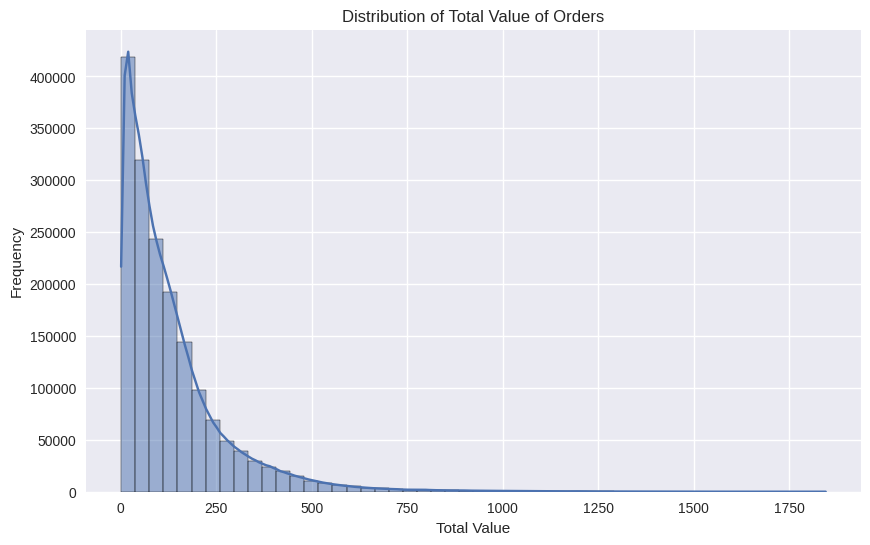

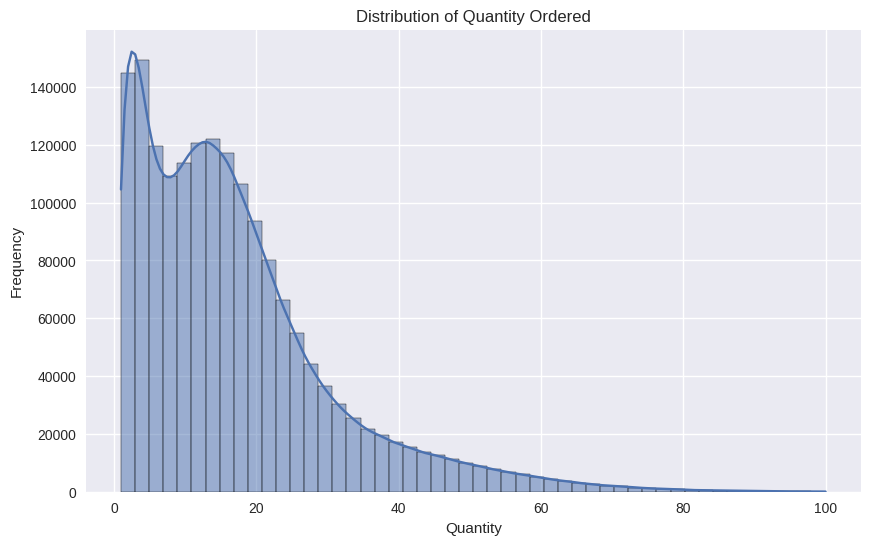

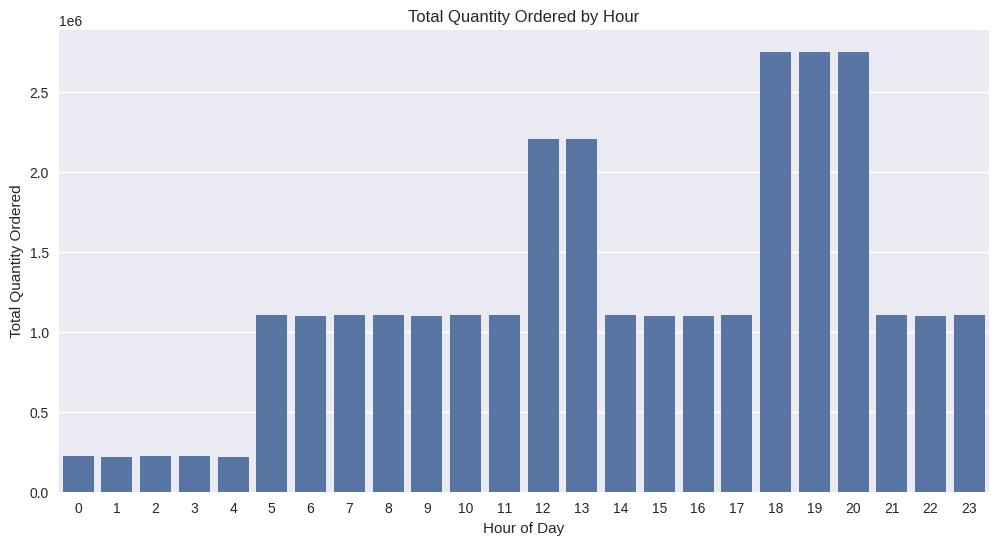

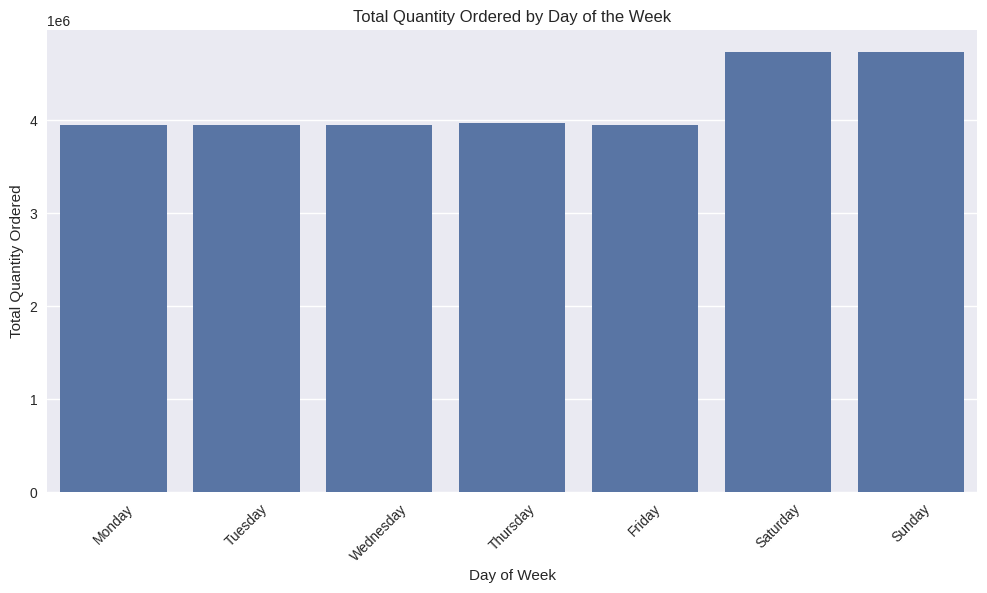

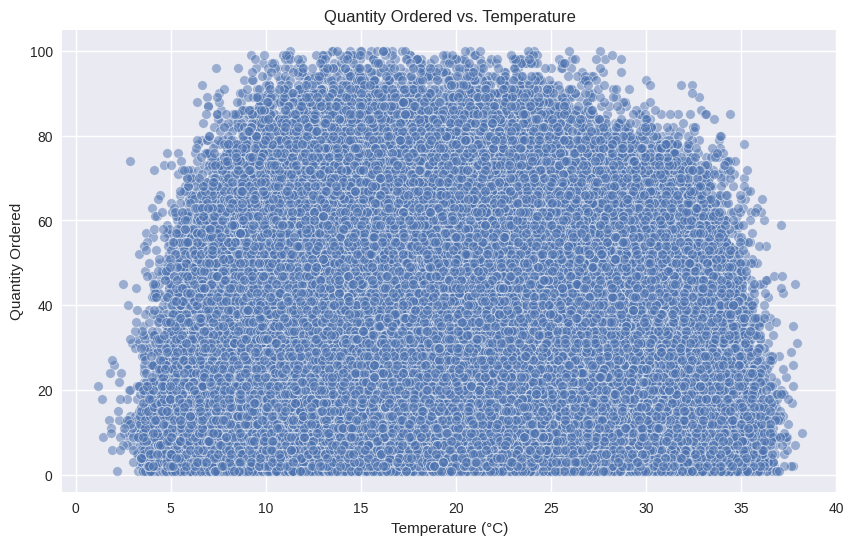

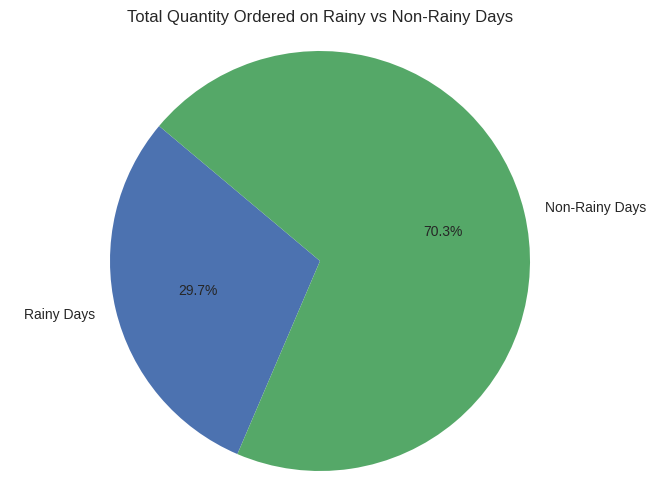

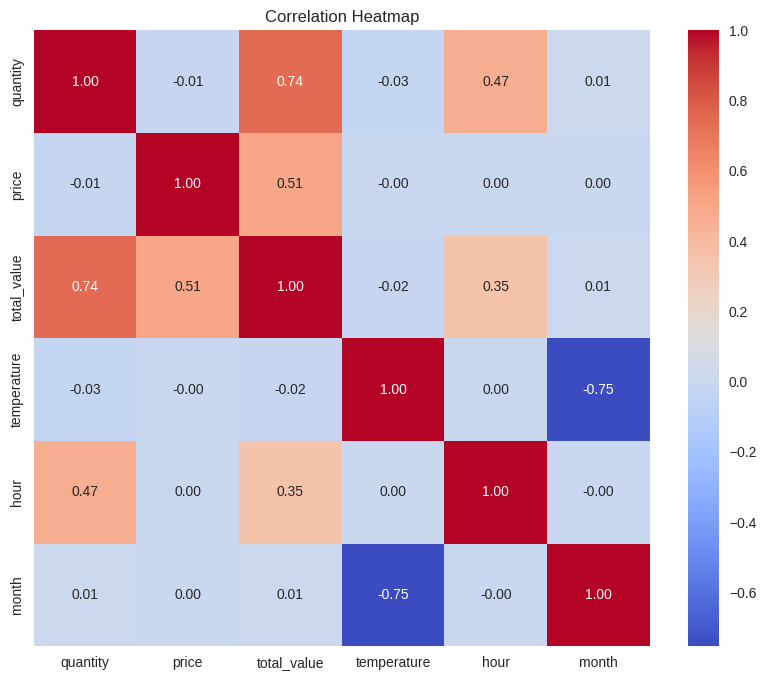

In [ ]:

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training dataset
train_df = pd.read_csv('dark_store_cleaned_train_data.csv')


# Visualizing the distribution of total_value
plt.figure(figsize=(10, 6))
sns.histplot(train_df['total_value'], bins=50, kde=True)
plt.title('Distribution of Total Value of Orders')
plt.xlabel('Total Value')
plt.ylabel('Frequency')
plt.show()

# Visualizing the distribution of quantity ordered
plt.figure(figsize=(10, 6))
sns.histplot(train_df['quantity'], bins=50, kde=True)
plt.title('Distribution of Quantity Ordered')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

# Time-based analysis: Orders per hour
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df['hour'] = train_df['timestamp'].dt.hour

orders_per_hour = train_df.groupby('hour')['quantity'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='quantity', data=orders_per_hour)
plt.title('Total Quantity Ordered by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Quantity Ordered')
plt.xticks(range(24))
plt.show()

# Time-based analysis: Orders per day of the week
train_df['day_of_week'] = train_df['timestamp'].dt.day_name()
orders_per_day = train_df.groupby('day_of_week')['quantity'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.figure(figsize=(12, 6))
sns.barplot(x=orders_per_day.index, y=orders_per_day.values)
plt.title('Total Quantity Ordered by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Quantity Ordered')
plt.xticks(rotation=45)
plt.show()

# Analyzing the impact of temperature on quantity ordered
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature', y='quantity', data=train_df, alpha=0.5)
plt.title('Quantity Ordered vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Quantity Ordered')
plt.show()

# Analyzing rainy days impact on quantity ordered
rainy_orders = train_df[train_df['is_rainy'] == True]['quantity'].sum()
non_rainy_orders = train_df[train_df['is_rainy'] == False]['quantity'].sum()

labels = ['Rainy Days', 'Non-Rainy Days']
sizes = [rainy_orders, non_rainy_orders]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.title('Total Quantity Ordered on Rainy vs Non-Rainy Days')
plt.show()

# Correlation heatmap for numerical features
correlation_matrix = train_df.select_dtypes(include=['number']).corr() # Select only numeric columns for correlation calculation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

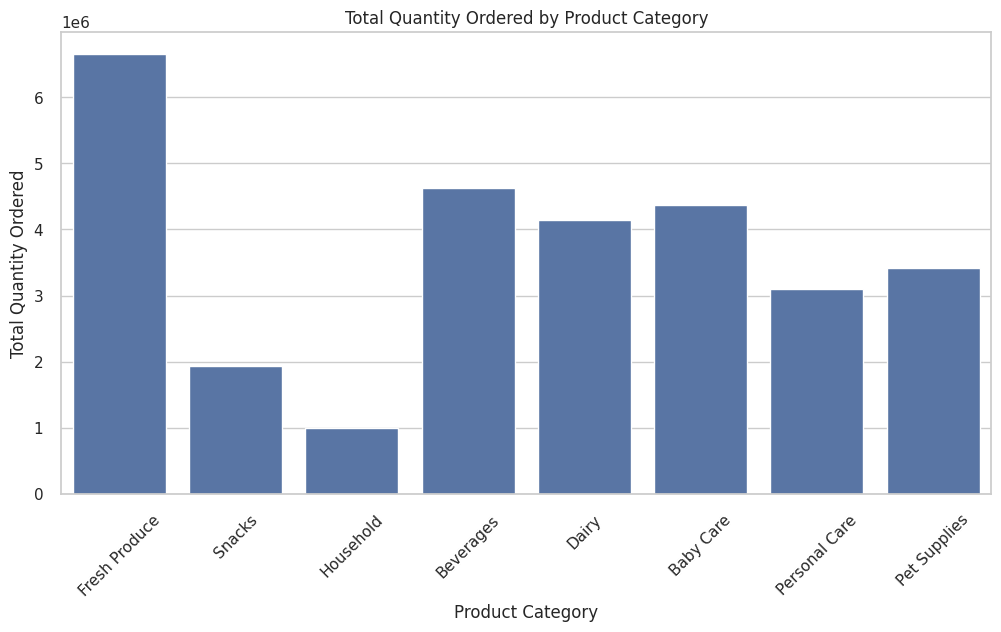

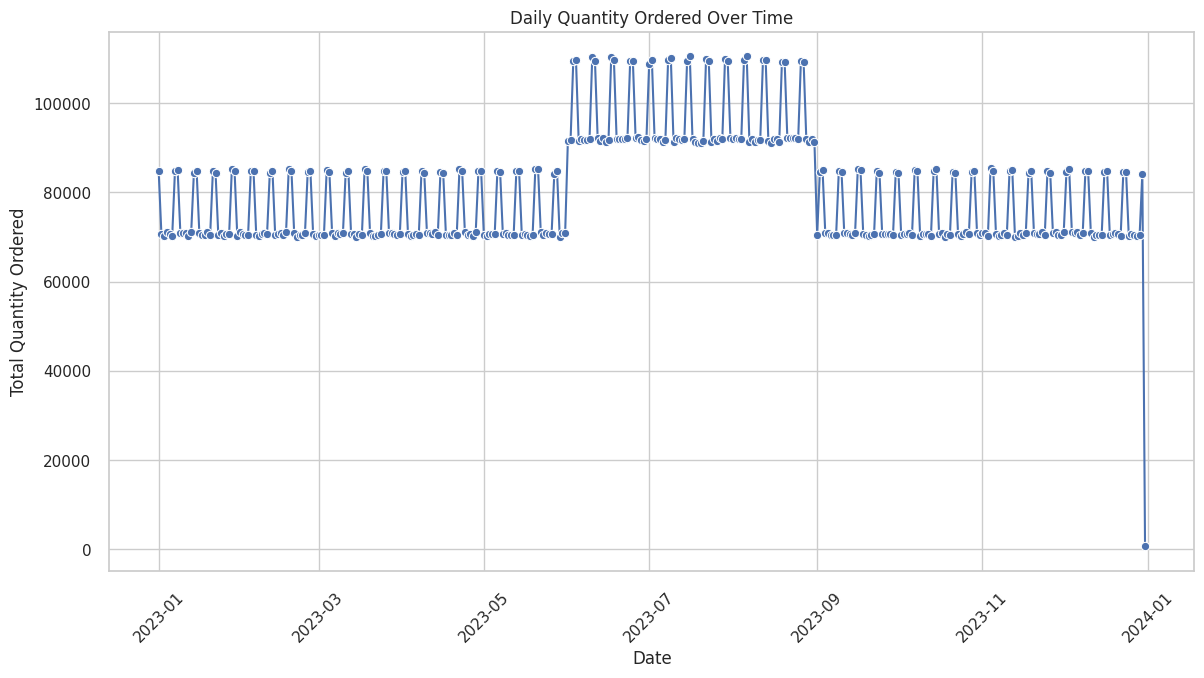

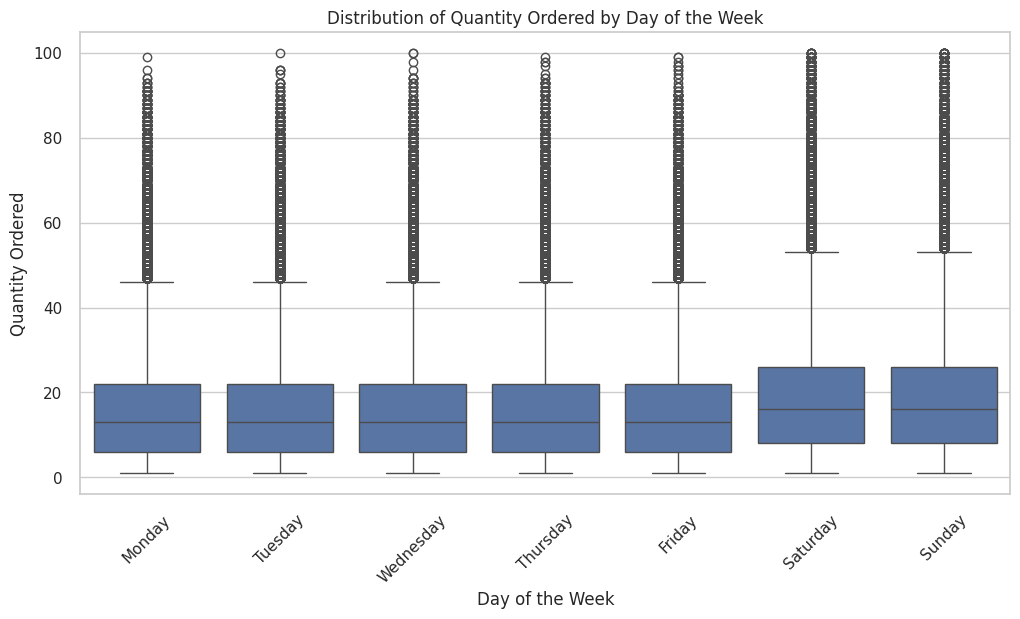

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
train_df = pd.read_csv('dark_store_cleaned_train_data.csv')

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# 1. Bar Plot: Total Quantity Ordered by Product Category
plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='quantity', data=train_df, estimator=sum, ci=None)
plt.title('Total Quantity Ordered by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Quantity Ordered')
plt.xticks(rotation=45)
plt.show()

# 2. Line Plot: Quantity Ordered Over Time (Daily)
train_df['date'] = pd.to_datetime(train_df['timestamp']).dt.date
daily_orders = train_df.groupby('date')['quantity'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='quantity', data=daily_orders, marker='o')
plt.title('Daily Quantity Ordered Over Time')
plt.xlabel('Date')
plt.ylabel('Total Quantity Ordered')
plt.xticks(rotation=45)
plt.show()


# 3. Box Plot: Distribution of Quantity Ordered by Day of Week
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='quantity', data=train_df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Distribution of Quantity Ordered by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Quantity Ordered')
plt.xticks(rotation=45)
plt.show()



Feature Engineering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# First, load the cleaned data
print("Loading the cleaned dataset...")
df = pd.read_csv('dark_store_cleaned_train_data.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Define the feature engineering function (same as before)
def engineer_features(df):
    """
    Create features for q-commerce demand prediction model

    Parameters:
    df (pandas.DataFrame): Input dataframe with raw features

    Returns:
    pandas.DataFrame: Dataframe with engineered features
    """
    # Create a copy to avoid modifying the original dataframe
    df_feat = df.copy()

    # === Temporal Features ===
    # Extract basic time components
    df_feat['hour'] = df_feat['timestamp'].dt.hour
    df_feat['day_of_week'] = df_feat['timestamp'].dt.dayofweek
    df_feat['day_of_month'] = df_feat['timestamp'].dt.day
    df_feat['month'] = df_feat['timestamp'].dt.month
    df_feat['quarter'] = df_feat['timestamp'].dt.quarter

    # Create time-based binary flags
    df_feat['is_weekend'] = df_feat['day_of_week'].isin([5, 6]).astype(int)
    df_feat['is_lunch_time'] = df_feat['hour'].isin([12, 13]).astype(int)
    df_feat['is_dinner_time'] = df_feat['hour'].isin([18, 19, 20]).astype(int)

    # === Lag Features ===
    # Group by product_id and zone_id to create meaningful lags
    group_cols = ['product_id', 'zone_id']

    # Create lag features for quantity
    for lag in [1, 2, 3, 24]:  # 1, 2, 3 hours ago and same hour yesterday
        df_feat[f'quantity_lag_{lag}'] = df_feat.groupby(group_cols)['quantity'].shift(lag)

    # Create rolling mean features for different windows
    for window in [3, 6, 24]:
        df_feat[f'quantity_rolling_mean_{window}h'] = (
            df_feat.groupby(group_cols)['quantity']
            .rolling(window=window, min_periods=1) # Added min_periods=1
            .mean()
            .reset_index(level=group_cols, drop=True) # Reset index to match df_feat
        )
    # === Categorical Encoding ===
    # Encode categorical variables
    le = LabelEncoder()
    df_feat['zone_id_encoded'] = le.fit_transform(df_feat['zone_id'])
    df_feat['category_encoded'] = le.fit_transform(df_feat['category'])

    # Create category-specific features
    category_avg_price = df_feat.groupby('category')['price'].transform('mean')
    df_feat['price_vs_category_avg'] = df_feat['price'] / category_avg_price

    # === Weather Features ===
    # Create weather-based features
    df_feat['temp_squared'] = df_feat['temperature'] ** 2
    df_feat['temp_normalized'] = (df_feat['temperature'] - 20) / 10

    # Create interaction features
    df_feat['rainy_weekend'] = df_feat['is_rainy'] * df_feat['is_weekend']
    df_feat['temp_rush_hour'] = df_feat['temp_normalized'] * (df_feat['is_lunch_time'] | df_feat['is_dinner_time'])

    # === Product Features ===
    # Calculate product popularity scores
    product_popularity = df_feat.groupby('product_id')['quantity'].transform('mean')
    df_feat['product_popularity_score'] = product_popularity / product_popularity.max()

    # === Zone Features ===
    # Calculate zone-specific metrics
    zone_total_orders = df_feat.groupby('zone_id')['quantity'].transform('sum')
    df_feat['zone_popularity_score'] = zone_total_orders / zone_total_orders.max()

    # Drop unnecessary columns and handle missing values
    df_feat.drop(['timestamp'], axis=1, inplace=True)
    df_feat.fillna(0, inplace=True)

    return df_feat

# Apply feature engineering
print("Applying feature engineering...")
engineered_features = engineer_features(df)

# Print information about the engineered features
print("\nShape of engineered features:", engineered_features.shape)
print("\nList of all features:")
for col in engineered_features.columns:
    print(f"- {col}")

# Save the engineered features to a new CSV file
output_file = 'dark_store_engineered_features.csv'
engineered_features.to_csv(output_file, index=False)
print(f"\nEngineered features saved to: {output_file}")

# Display sample of the engineered features
print("\nSample of engineered features:")
print(engineered_features.head())

# Display basic statistics of numerical features
print("\nBasic statistics of numerical features:")
print(engineered_features.describe())

Loading the cleaned dataset...
Applying feature engineering...

Shape of engineered features: (1714971, 32)

List of all features:
- product_id
- category
- zone_id
- quantity
- price
- total_value
- temperature
- is_rainy
- hour
- day_of_week
- month
- day_of_month
- quarter
- is_weekend
- is_lunch_time
- is_dinner_time
- quantity_lag_1
- quantity_lag_2
- quantity_lag_3
- quantity_lag_24
- quantity_rolling_mean_3h
- quantity_rolling_mean_6h
- quantity_rolling_mean_24h
- zone_id_encoded
- category_encoded
- price_vs_category_avg
- temp_squared
- temp_normalized
- rainy_weekend
- temp_rush_hour
- product_popularity_score
- zone_popularity_score

Engineered features saved to: dark_store_engineered_features.csv

Sample of engineered features:
  product_id       category zone_id  quantity  price  total_value  \
0       P000  Fresh Produce      Z1         4   8.39        33.56   
1       P000  Fresh Produce      Z2         1   8.39         8.39   
2       P000  Fresh Produce      Z3        

Feature Selection

In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 15.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import spearmanr

def select_features(df, target_col='quantity', correlation_threshold=0.8, vif_threshold=5, n_top_features=20):
    """
    Perform feature selection using multiple methods

    Parameters:
    df (pandas.DataFrame): Input dataframe with engineered features
    target_col (str): Name of the target column
    correlation_threshold (float): Threshold for correlation-based feature removal
    vif_threshold (float): Threshold for VIF-based feature removal
    n_top_features (int): Number of top features to select

    Returns:
    list: Selected feature names
    dict: Feature importance scores
    """
    print("Starting feature selection process...")

    # Separate features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # Remove non-numeric columns and store them separately
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X_numeric = X[numeric_cols]

    # Step 1: Correlation Analysis
    print("\n1. Performing correlation analysis...")

    # Calculate correlation matrix
    correlation_matrix = X_numeric.corr()

    # Find highly correlated feature pairs
    highly_correlated = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                highly_correlated.append((colname_i, colname_j))

    print(f"Found {len(highly_correlated)} highly correlated feature pairs")

    # Step 2: VIF Analysis
    print("\n2. Performing VIF analysis...")

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_numeric.columns
    vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i)
                       for i in range(X_numeric.shape[1])]

    # Identify features with high VIF
    high_vif_features = vif_data[vif_data["VIF"] > vif_threshold]["Feature"].tolist()
    print(f"Found {len(high_vif_features)} features with high VIF")

    # Step 3: Random Forest Feature Importance
    print("\n3. Calculating Random Forest feature importance...")

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    X_scaled = pd.DataFrame(X_scaled, columns=X_numeric.columns)

    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)

    # Get feature importance scores
    feature_importance = pd.DataFrame({
        'feature': X_numeric.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    # Step 4: Combine all methods for final feature selection
    print("\n4. Combining all methods for final feature selection...")

    # Start with top important features
    selected_features = feature_importance['feature'].head(n_top_features).tolist()

    # Remove highly correlated features
    for feat1, feat2 in highly_correlated:
        if feat1 in selected_features and feat2 in selected_features:
            # Remove the one with lower importance
            if (feature_importance[feature_importance['feature'] == feat1]['importance'].iloc[0] <
                feature_importance[feature_importance['feature'] == feat2]['importance'].iloc[0]):
                selected_features.remove(feat1)
            else:
                selected_features.remove(feat2)

    # Remove features with high VIF
    selected_features = [f for f in selected_features if f not in high_vif_features]

    # Create importance dictionary for selected features
    importance_dict = dict(zip(feature_importance['feature'], feature_importance['importance']))

    print(f"\nFinal number of selected features: {len(selected_features)}")

    return selected_features, importance_dict


Loading engineered features...
Starting feature selection process...

1. Performing correlation analysis...
Found 10 highly correlated feature pairs

2. Performing VIF analysis...
Found 13 features with high VIF

3. Calculating Random Forest feature importance...

4. Combining all methods for final feature selection...

Final number of selected features: 10

Top selected features and their importance scores:
quantity_lag_24: 0.5309
hour: 0.0510
price: 0.0505
is_lunch_time: 0.0025
is_dinner_time: 0.0020
price_vs_category_avg: 0.0007
category_encoded: 0.0002
day_of_month: 0.0001
temp_rush_hour: 0.0001
day_of_week: 0.0000


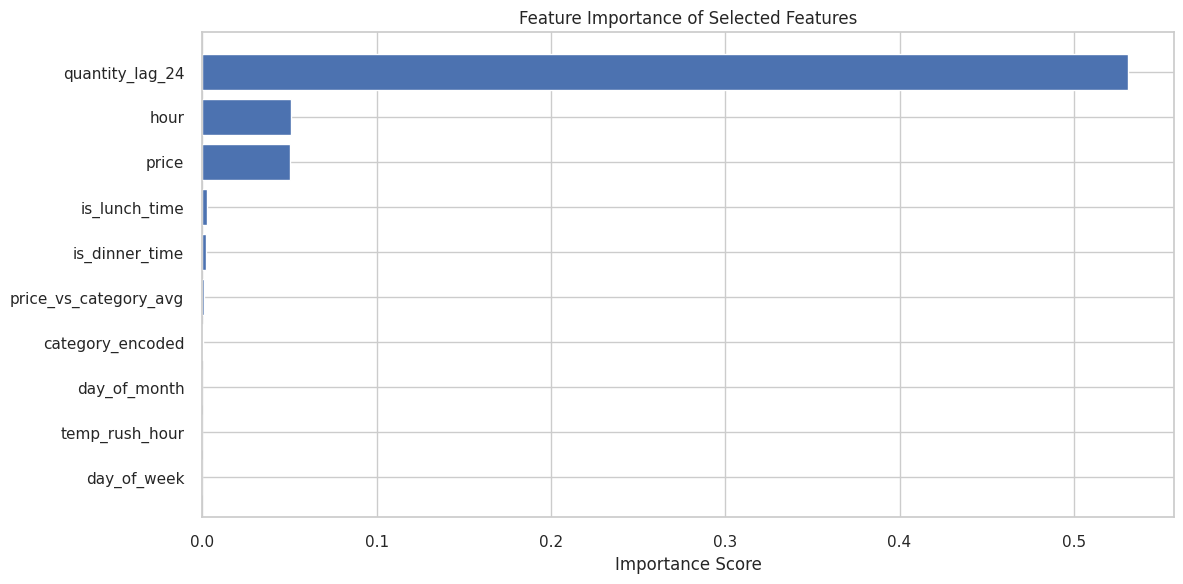


Selected features saved to: dark_store_selected_features.csv


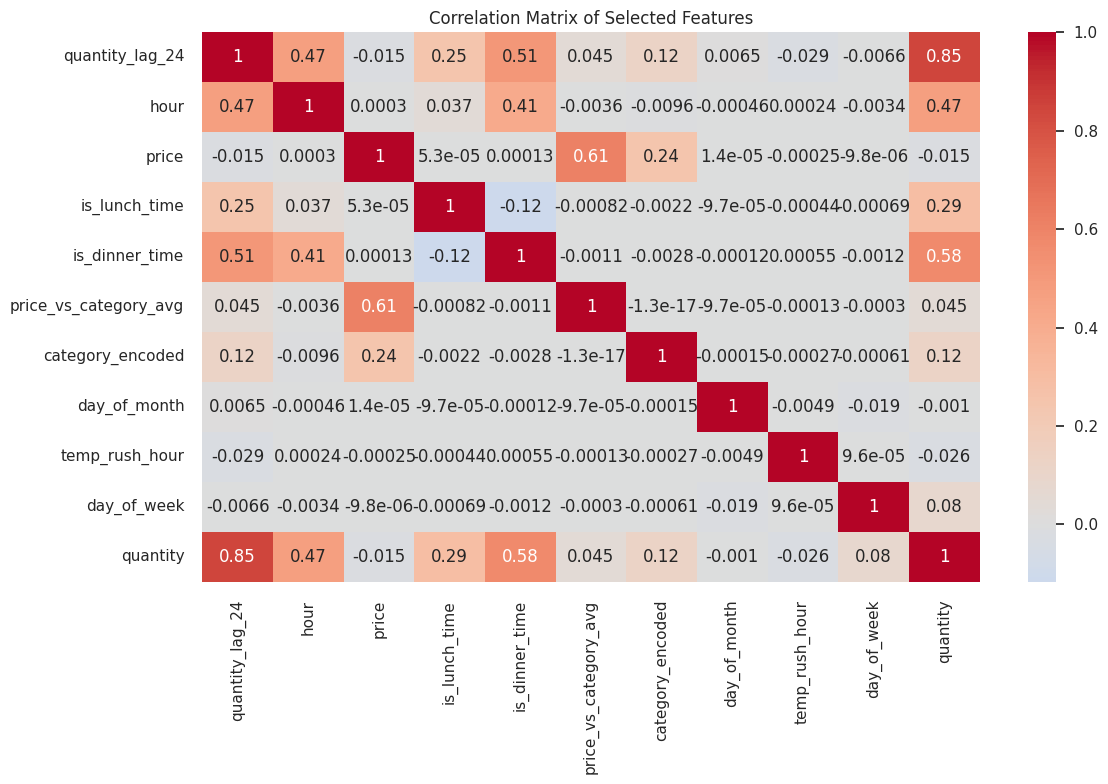

In [ ]:
# Load the engineered features
print("Loading engineered features...")
df = pd.read_csv('dark_store_engineered_features.csv')

# Perform feature selection
selected_features, importance_dict = select_features(df)

# Print results
print("\nTop selected features and their importance scores:")
for feature in selected_features:
    print(f"{feature}: {importance_dict[feature]:.4f}")

# Create visualization of feature importance
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': [importance_dict[f] for f in selected_features]
}).sort_values('importance', ascending=True)

plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance of Selected Features')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Save selected features to a new CSV file
selected_df = df[selected_features + ['quantity']]
selected_df.to_csv('dark_store_selected_features.csv', index=False)
print(f"\nSelected features saved to: dark_store_selected_features.csv")

# Print correlation matrix of selected features
correlation_matrix = selected_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.show()

Prediction model

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.2 MB/s eta 0:00:00


Loading selected features dataset...
Starting model evaluation process...

Evaluating models using time series cross-validation...

Evaluating Linear Regression...
Average RMSE: 6.5061
Average MAE: 4.8381
Average R²: 0.7753

Evaluating Ridge Regression...
Average RMSE: 6.5061
Average MAE: 4.8381
Average R²: 0.7753

Evaluating Lasso Regression...
Average RMSE: 6.8366
Average MAE: 5.0943
Average R²: 0.7533

Evaluating Random Forest...
Average RMSE: 5.7534
Average MAE: 4.1404
Average R²: 0.8252

Evaluating Gradient Boosting...
Average RMSE: 5.5864
Average MAE: 4.0224
Average R²: 0.8356

Evaluating XGBoost...
Average RMSE: 5.4423
Average MAE: 3.8937
Average R²: 0.8440

Plotting model comparison results...


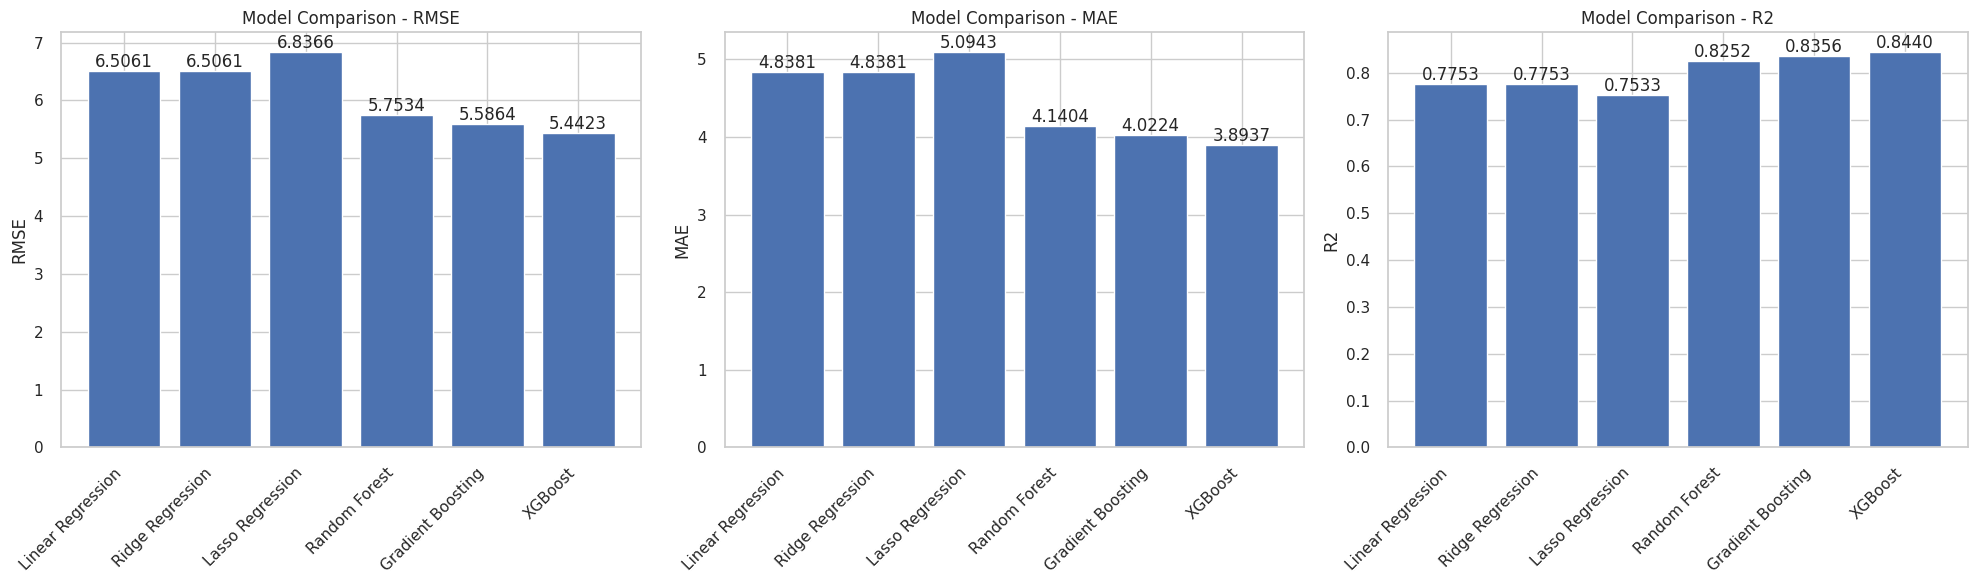


Best model based on RMSE: XGBoost
Best model metrics:
RMSE: 5.4423
MAE: 3.8937
R²: 0.8440

Training final model with best algorithm...


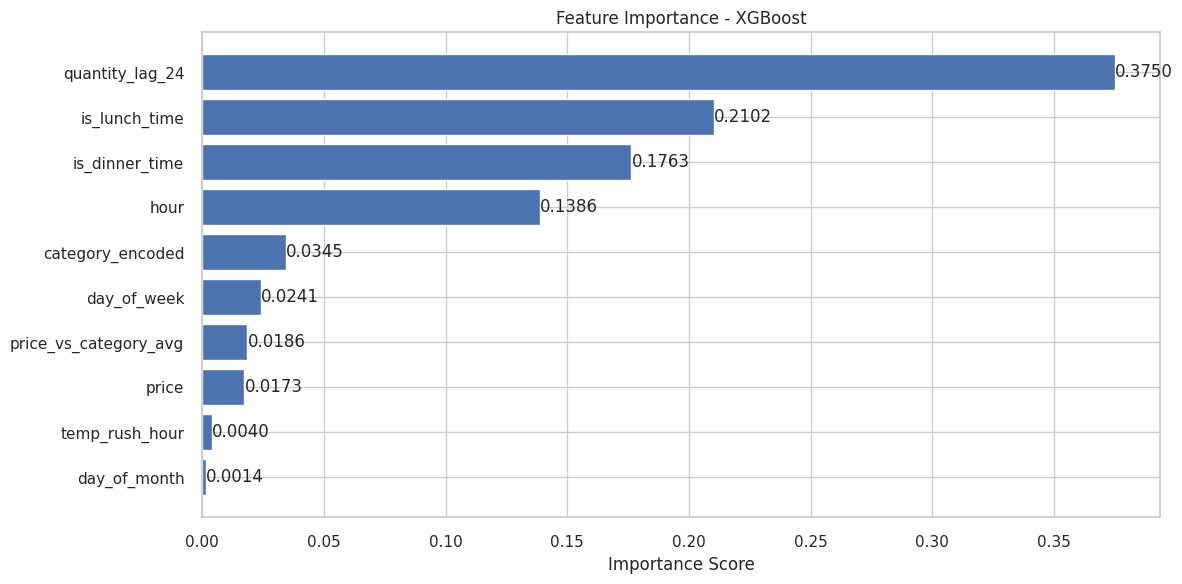


Best model saved as: best_qcommerce_model.joblib

Model Performance Summary:
                     RMSE     MAE      R2
Linear Regression  6.5061  4.8381  0.7753
Ridge Regression   6.5061  4.8381  0.7753
Lasso Regression   6.8366  5.0943  0.7533
Random Forest      5.7534  4.1404  0.8252
Gradient Boosting  5.5864  4.0224  0.8356
XGBoost            5.4423  3.8937  0.8440


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the selected features dataset
print("Loading selected features dataset...")
df = pd.read_csv('dark_store_selected_features.csv')

class ModelEvaluator:
    def __init__(self, n_splits=5):
        self.n_splits = n_splits
        self.models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'Lasso Regression': Lasso(alpha=1.0),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
        }
        self.results = {}

    def prepare_data(self, df, target_col='quantity'):
        """Prepare data for modeling"""
        X = df.drop(target_col, axis=1)
        y = df[target_col]

        # Scale the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        return X_scaled, y, X.columns

    def evaluate_models(self, X, y):
        """Evaluate all models using time series cross-validation"""
        print("\nEvaluating models using time series cross-validation...")

        # Initialize TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=self.n_splits)

        # Dictionary to store results
        metrics = {
            'RMSE': [],
            'MAE': [],
            'R2': []
        }

        for model_name, model in self.models.items():
            print(f"\nEvaluating {model_name}...")
            model_metrics = {
                'RMSE': [],
                'MAE': [],
                'R2': []
            }

            # Perform time series cross-validation
            for train_idx, val_idx in tscv.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                # Train model
                model.fit(X_train, y_train)

                # Make predictions
                y_pred = model.predict(X_val)

                # Calculate metrics
                model_metrics['RMSE'].append(np.sqrt(mean_squared_error(y_val, y_pred)))
                model_metrics['MAE'].append(mean_absolute_error(y_val, y_pred))
                model_metrics['R2'].append(r2_score(y_val, y_pred))

            # Store average metrics
            self.results[model_name] = {
                'RMSE': np.mean(model_metrics['RMSE']),
                'MAE': np.mean(model_metrics['MAE']),
                'R2': np.mean(model_metrics['R2'])
            }

            print(f"Average RMSE: {self.results[model_name]['RMSE']:.4f}")
            print(f"Average MAE: {self.results[model_name]['MAE']:.4f}")
            print(f"Average R²: {self.results[model_name]['R2']:.4f}")

    def plot_results(self):
        """Plot comparison of model performances"""
        # Create a figure with adjusted size for better readability
        metrics = ['RMSE', 'MAE', 'R2']
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        for i, metric in enumerate(metrics):
            values = [self.results[model][metric] for model in self.models.keys()]
            ax = axes[i]
            bars = ax.bar(self.models.keys(), values)
            ax.set_title(f'Model Comparison - {metric}', fontsize=12)
            ax.set_xticklabels(self.models.keys(), rotation=45, ha='right')
            ax.set_ylabel(metric)

            # Add value labels on top of each bar
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.4f}',
                       ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def get_best_model(self, metric='RMSE'):
        """Return the best model based on specified metric"""
        if metric in ['RMSE', 'MAE']:
            best_model = min(self.results.items(), key=lambda x: x[1][metric])
        else:  # R2
            best_model = max(self.results.items(), key=lambda x: x[1][metric])
        return best_model

# Initialize and run model evaluation
print("Starting model evaluation process...")
evaluator = ModelEvaluator()
X, y, feature_names = evaluator.prepare_data(df)
evaluator.evaluate_models(X, y)

# Plot results
print("\nPlotting model comparison results...")
evaluator.plot_results()

# Get best model
best_model_name, best_metrics = evaluator.get_best_model(metric='RMSE')
print(f"\nBest model based on RMSE: {best_model_name}")
print(f"Best model metrics:")
print(f"RMSE: {best_metrics['RMSE']:.4f}")
print(f"MAE: {best_metrics['MAE']:.4f}")
print(f"R²: {best_metrics['R2']:.4f}")

# Train final model with best algorithm
print("\nTraining final model with best algorithm...")
best_model = evaluator.models[best_model_name]
best_model.fit(X, y)

# Feature importance plot for tree-based models
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    plt.figure(figsize=(12, 6))
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)

    bars = plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance Score')

    # Add value labels to the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}',
                ha='left', va='center')

    plt.tight_layout()
    plt.show()

# Save the best model
import joblib
model_filename = 'best_qcommerce_model.joblib'
joblib.dump(best_model, model_filename)
print(f"\nBest model saved as: {model_filename}")

# Create a summary table of all model performances
summary_df = pd.DataFrame.from_dict(evaluator.results, orient='index')
print("\nModel Performance Summary:")
print(summary_df.round(4).to_string())

Hyperparameter tuning

Loading data and best model...
Starting tuning process for XGBRegressor

Starting hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Plotting cross-validation results...


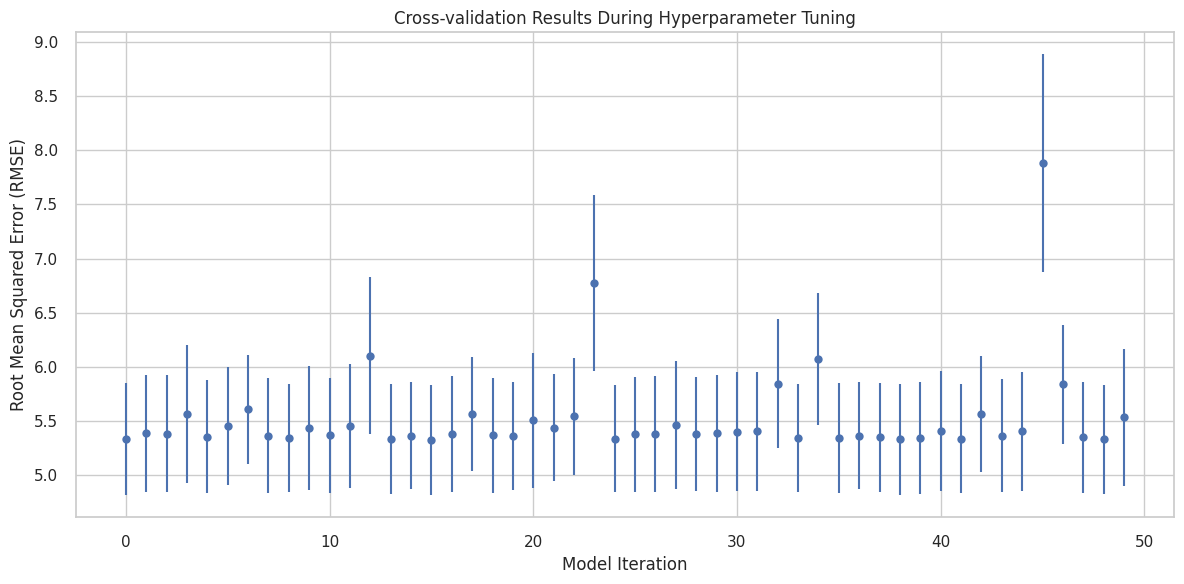


Evaluating tuned model...

Best Parameters:
subsample: 0.9
n_estimators: 100
min_child_weight: 5
max_depth: 6
learning_rate: 0.1
gamma: 0.3
colsample_bytree: 0.8

Tuned Model Performance:
RMSE: 5.3216
MAE: 3.8257
R²: 0.8507


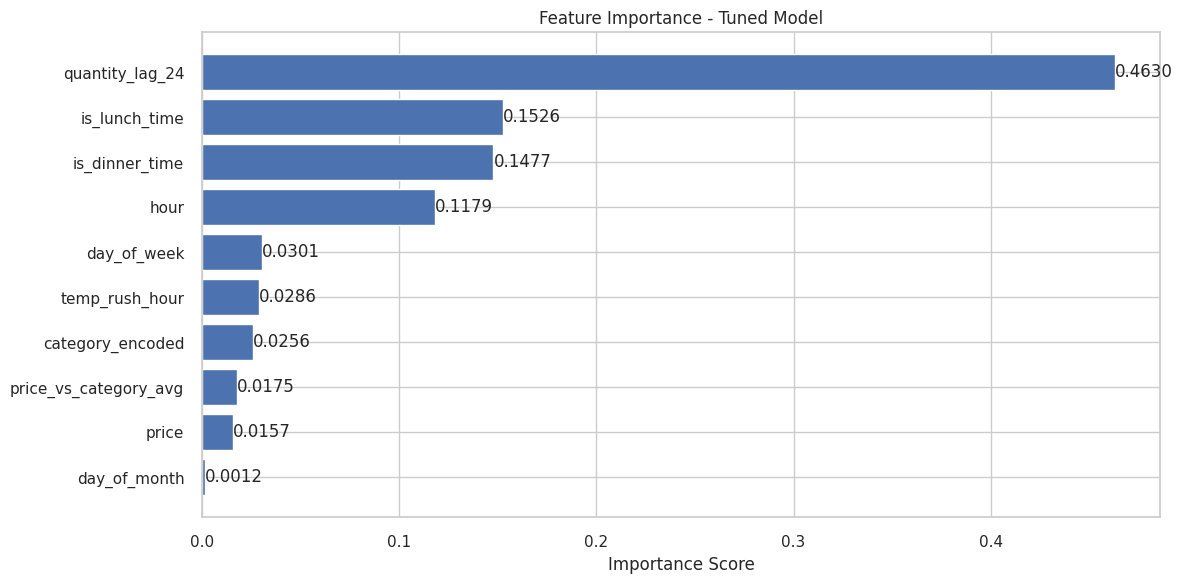


Tuned model saved as: tuned_qcommerce_model.joblib

Performance Comparison:
      Original Model  Tuned Model
RMSE          5.3216       5.3216
MAE           3.8257       3.8257
R2            0.8507       0.8507


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Load the data and best model
print("Loading data and best model...")
df = pd.read_csv('dark_store_selected_features.csv')
best_model = joblib.load('best_qcommerce_model.joblib')
best_model_name = type(best_model).__name__

# Define parameter grids for each model type
param_grids = {
    'RandomForestRegressor': {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [10, 20, 30, 40, 50, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'max_depth': [3, 4, 5, 6, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0]
    },
    'XGBRegressor': {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0, 0.1, 0.2, 0.3]
    }
}

class ModelTuner:
    def __init__(self, model, param_grid, n_splits=5):
        self.model = model
        self.param_grid = param_grid
        self.n_splits = n_splits
        self.best_params = None
        self.best_model = None
        self.cv_results = None

    def prepare_data(self, df, target_col='quantity'):
        """Prepare data for modeling"""
        X = df.drop(target_col, axis=1)
        y = df[target_col]

        # Scale the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        return X_scaled, y, X.columns

    def tune_model(self, X, y, n_iter=50):
        """Perform hyperparameter tuning using RandomizedSearchCV"""
        print("\nStarting hyperparameter tuning...")

        # Set up TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=self.n_splits)

        # Initialize RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=self.model,
            param_distributions=self.param_grid,
            n_iter=n_iter,
            cv=tscv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            random_state=42,
            verbose=2
        )

        # Fit RandomizedSearchCV
        random_search.fit(X, y)

        self.best_params = random_search.best_params_
        self.best_model = random_search.best_estimator_
        self.cv_results = random_search.cv_results_

        return self.best_model, self.best_params

    def plot_cv_results(self):
        """Plot cross-validation results"""
        results = pd.DataFrame(self.cv_results)

        plt.figure(figsize=(12, 6))
        plt.errorbar(range(len(results)),
                    -results['mean_test_score'],
                    yerr=results['std_test_score'],
                    fmt='o')
        plt.xlabel('Model Iteration')
        plt.ylabel('Root Mean Squared Error (RMSE)')
        plt.title('Cross-validation Results During Hyperparameter Tuning')
        plt.tight_layout()
        plt.show()

    def evaluate_best_model(self, X, y):
        """Evaluate the best model using time series cross-validation"""
        tscv = TimeSeriesSplit(n_splits=self.n_splits)
        metrics = {
            'RMSE': [],
            'MAE': [],
            'R2': []
        }

        for train_idx, val_idx in tscv.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            self.best_model.fit(X_train, y_train)
            y_pred = self.best_model.predict(X_val)

            metrics['RMSE'].append(np.sqrt(mean_squared_error(y_val, y_pred)))
            metrics['MAE'].append(mean_absolute_error(y_val, y_pred))
            metrics['R2'].append(r2_score(y_val, y_pred))

        return {k: np.mean(v) for k, v in metrics.items()}

# Initialize tuning process
print(f"Starting tuning process for {best_model_name}")
tuner = ModelTuner(best_model, param_grids[best_model_name])
X, y, feature_names = tuner.prepare_data(df)

# Perform tuning
best_model, best_params = tuner.tune_model(X, y)

# Plot cross-validation results
print("\nPlotting cross-validation results...")
tuner.plot_cv_results()

# Evaluate the tuned model
print("\nEvaluating tuned model...")
metrics = tuner.evaluate_best_model(X, y)

print("\nBest Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

print("\nTuned Model Performance:")
print(f"RMSE: {metrics['RMSE']:.4f}")
print(f"MAE: {metrics['MAE']:.4f}")
print(f"R²: {metrics['R2']:.4f}")

# If the model is tree-based, plot feature importance
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(12, 6))
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)

    bars = plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title('Feature Importance - Tuned Model')
    plt.xlabel('Importance Score')

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}',
                ha='left', va='center')

    plt.tight_layout()
    plt.show()

# Save the tuned model
tuned_model_filename = 'tuned_qcommerce_model.joblib'
joblib.dump(best_model, tuned_model_filename)
print(f"\nTuned model saved as: {tuned_model_filename}")

# Compare with original model performance
original_model = joblib.load('best_qcommerce_model.joblib')
original_metrics = tuner.evaluate_best_model(X, y)

print("\nPerformance Comparison:")
comparison_df = pd.DataFrame({
    'Original Model': original_metrics,
    'Tuned Model': metrics
}).round(4)
print(comparison_df)

Pipeline

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class QcommercePredictionPipeline:
    def __init__(self, model_path='tuned_qcommerce_model.joblib'):
        """
        Initialize the prediction pipeline

        Parameters:
        model_path: path to the saved tuned model
        """
        print("Initializing prediction pipeline...")
        self.model = joblib.load(model_path)
        self.scaler = StandardScaler()

    def preprocess_data(self, df):
        """
        Preprocess input data for prediction
        """
        # Create a copy to avoid modifying the original data
        df_processed = df.copy()

        # Ensure all required columns are present
        required_columns = ['timestamp', 'category', 'zone_id',
                          'price', 'temperature', 'is_rainy'] # Removed product_id from required columns
        missing_cols = [col for col in required_columns if col not in df_processed.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        # Convert timestamp to datetime if it's not already
        df_processed['timestamp'] = pd.to_datetime(df_processed['timestamp'])

        # Extract temporal features
        df_processed['hour'] = df_processed['timestamp'].dt.hour
        df_processed['day_of_week'] = df_processed['timestamp'].dt.dayofweek

        # Create time-based binary flags
        df_processed['is_weekend'] = df_processed['day_of_week'].isin([5, 6]).astype(int)

        # Encode categorical variables
        df_processed = pd.get_dummies(df_processed,
                                    columns=['category', 'zone_id'], #Removed product_id from encoding
                                    drop_first=True)

        return df_processed

    def make_predictions(self, df):
        """
        Make predictions using the tuned model
        """
        # Preprocess the data
        df_processed = self.preprocess_data(df)

        # Remove timestamp column if present
        if 'timestamp' in df_processed.columns:
            df_processed = df_processed.drop('timestamp', axis=1)

        #Remove day_of_week to match training data
        if 'day_of_week' in df_processed.columns:
            df_processed = df_processed.drop('day_of_week', axis=1)

        # Remove product_id column before scaling
        if 'product_id' in df_processed.columns:
            df_processed = df_processed.drop('product_id', axis=1)

        # Scale the features
        scaled_features = self.scaler.fit_transform(df_processed)

        # Make predictions
        predictions = self.model.predict(scaled_features)

        # Add predictions to original dataframe
        df['predicted_quantity'] = predictions.round(0).astype(int)

        return df


    def evaluate_predictions(self, df, actual_col='quantity', pred_col='predicted_quantity'):
        """
        Evaluate prediction accuracy
        """
        metrics = {
            'RMSE': np.sqrt(mean_squared_error(df[actual_col], df[pred_col])),
            'MAE': mean_absolute_error(df[actual_col], df[pred_col]),
            'R2': r2_score(df[actual_col], df[pred_col])
        }

        return metrics

    def plot_predictions(self, df, actual_col='quantity', pred_col='predicted_quantity'):
        """
        Create visualizations of predictions vs actual values
        """
        # Scatter plot of predicted vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(df[actual_col], df[pred_col], alpha=0.5)
        plt.plot([df[actual_col].min(), df[actual_col].max()],
                [df[actual_col].min(), df[actual_col].max()],
                'r--', lw=2)
        plt.xlabel('Actual Quantity')
        plt.ylabel('Predicted Quantity')
        plt.title('Predicted vs Actual Quantities')
        plt.tight_layout()
        plt.show()

        # Distribution of prediction errors
        errors = df[actual_col] - df[pred_col]
        plt.figure(figsize=(10, 6))
        sns.histplot(errors, bins=50)
        plt.xlabel('Prediction Error')
        plt.ylabel('Count')
        plt.title('Distribution of Prediction Errors')
        plt.tight_layout()
        plt.show()

        # Time series plot for a sample product-zone combination
        sample_data = df.sample(n=1, random_state=42)[['product_id', 'zone_id']].iloc[0]
        sample_df = df[
            (df['product_id'] == sample_data['product_id']) &
            (df['zone_id'] == sample_data['zone_id'])
        ].sort_values('timestamp')

        plt.figure(figsize=(12, 6))
        plt.plot(sample_df['timestamp'], sample_df[actual_col], label='Actual')
        plt.plot(sample_df['timestamp'], sample_df[pred_col], label='Predicted')
        plt.xlabel('Timestamp')
        plt.ylabel('Quantity')
        plt.title(f'Actual vs Predicted Quantities\nProduct: {sample_data["product_id"]}, Zone: {sample_data["zone_id"]}')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def generate_sample_prediction_data(n_samples=100):
    """
    Generate sample data for prediction demonstration
    """
    timestamps = pd.date_range(start='2024-01-01',
                             end='2024-01-31',
                             freq='H')[:n_samples]

    data = {
        'timestamp': timestamps,
        'product_id': np.random.choice(['P001', 'P002', 'P003'], n_samples),
        'category': np.random.choice(['Fresh Produce', 'Dairy', 'Beverages'], n_samples),
        'zone_id': np.random.choice(['Z1', 'Z2', 'Z3', 'Z4'], n_samples),
        'price': np.random.uniform(2, 20, n_samples),
        'temperature': np.random.normal(20, 5, n_samples),
        'is_rainy': np.random.choice([0, 1], n_samples),
        'quantity': np.random.poisson(10, n_samples)  # Actual quantities for demonstration
    }

    return pd.DataFrame(data)

# Example usage
if __name__ == "__main__":
    # Initialize the pipeline
    print("Initializing prediction pipeline...")
    pipeline = QcommercePredictionPipeline()

    # Load test data (or generate sample data)
    print("\nLoading test data...")
    try:
        # Try to load actual test data
        test_df = pd.read_csv('dark_store_test_data.csv')
        print("Using actual test data")
    except FileNotFoundError:
        # Generate sample data if test data is not available
        print("Test data not found. Using generated sample data")
        test_df = generate_sample_prediction_data()

    # Make predictions
    print("\nMaking predictions...")
    predictions_df = pipeline.make_predictions(test_df)

    # Evaluate predictions
    print("\nEvaluating predictions...")
    metrics = pipeline.evaluate_predictions(predictions_df)
    print("\nPrediction Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plot predictions
    print("\nGenerating prediction visualizations...")
    pipeline.plot_predictions(predictions_df)

    # Save predictions to CSV
    output_file = 'qcommerce_predictions.csv'
    predictions_df.to_csv(output_file, index=False)
    print(f"\nPredictions saved to: {output_file}")

    # Print sample of predictions
    print("\nSample of predictions:")
    print(predictions_df[['timestamp', 'product_id', 'zone_id',
                         'quantity', 'predicted_quantity']].head())

Initializing prediction pipeline...
Initializing prediction pipeline...


FileNotFoundError: [Errno 2] No such file or directory: 'tuned_qcommerce_model.joblib'